In [1]:
from common import hallmark as hm
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from common import dalt
import imageio
from common import io_ipole as io

In [50]:
pf_SPO = hm.ParaFrame('spectral_index/img_dump/SPO/SgrA_{aspin:g}_{freq}_{inc}.h5')
pf_beta = hm.ParaFrame('spectral_index/img_dump/beta/SgrA_{aspin:g}_{freq}_{inc}.h5')

for k in set(pf_SPO.keys()) - {'path'}:
    globals()[k] = np.unique(pf_SPO[k])
    print(k, globals()[k][:16])

def get_df(path):
    df = pd.read_csv(path, sep='\t')
    return df

def get_intensity_map(path, s=0, **kwwargs):
    hfp = h5py.File(path,'r')    
    imagep = np.copy(hfp['pol']).transpose((1,0,2))
    if s == 0:
        I = imagep[:,:,0]
    if s == 1:
        I = imagep
    return I


def get_alpha_map(pf, **kwargs):
    sel_low = pf(freq=freq[0])
    sel_high = pf(freq=freq[1])

    I_low = get_intensity_map(sel_low.path.iloc[0], **kwargs)
    I_high = get_intensity_map(sel_high.path.iloc[0], **kwargs)

    avg_I = (I_low + I_high) / 2

    numerator = np.log(I_low / I_high)
    denominator = np.log(float(freq[0]) / float(freq[1]))

    alpha = numerator / denominator

    # Mean spectral index
    print(np.log(np.mean(I_low) / np.mean(I_high)) / denominator)
    
    # Scaling the opacity according to intensity
    opacity = avg_I / np.max(avg_I)
    opacity[avg_I > np.max(avg_I) * 0.8] = 1
    return alpha, opacity

def colorbar(mappable):
  """ the way matplotlib colorbar should have been implemented """
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  ax = mappable.axes
  fig = ax.figure
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  return fig.colorbar(mappable, cax=cax)

def vizrow(pf, viz_type, v='2141.e8', **kwargs):
    fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    print(f"Rendering frequency {v}")

    lst = []

    if viz_type == 'alpha':
        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])
            alpha, opacity = get_alpha_map(sel, **kwargs)

            #tmp = axes[a].imshow((alpha.T), origin='lower', cmap='jet', alpha=opacity, **kwargs)
            tmp = axes[a].imshow(alpha, origin='lower', cmap='jet', **kwargs)
            colorbar(tmp)

            ax.set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(alpha)

    elif viz_type == 'I':
        for a, ax in enumerate(axes):
            sel = pf_SPO(aspin=aspin[a])(freq=v)
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            im = axes[a].imshow((I.T), cmap='afmhot', origin='lower', **kwargs)  
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(I)

    elif viz_type == 'LP':
        for a, ax in enumerate(axes):
            sel = pf_SPO(aspin=aspin[a])(freq=v)
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            Q = img.value[:,:,1]
            U = img.value[:,:,2]

            lp = np.sqrt(Q*Q+U*U)
            im = axes[a].imshow((lp.T), cmap='afmhot', origin='lower', **kwargs)  
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(lp)

    elif viz_type == 'LP_frac':
        for a, ax in enumerate(axes):
            sel = pf_SPO(aspin=aspin[a])(freq=v)
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            Q = img.value[:,:,1]
            U = img.value[:,:,2]

            Imaskval = np.abs(I.min()) * 100.
            Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)
            

            lpfrac = 100.*np.sqrt(Q*Q+U*U)/I
            lpfrac[np.abs(I)<Imaskval] = np.nan
            ax.set_facecolor('black')
            im = ax.imshow(lpfrac.T, cmap='jet', vmin=0., vmax=100., origin='lower', )
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(lpfrac)

    elif viz_type == 'tauI':

        for a, ax in enumerate(axes):
            sel = pf_SPO(aspin=aspin[a])(freq='2141.e8')
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            tau = img.tauI
            I = img.value[:,:,0]
            print(np.sum(tau * I) / np.sum(I))
            im = axes[a].imshow(tau.T, cmap='jet', vmax=10, origin='lower')  
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(tau)

    elif viz_type == 'EVPA':

        for a, ax in enumerate(axes):
            sel = pf_SPO(aspin=aspin[a])(freq='2141.e8')
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            Q = img.value[:,:,1]
            U = img.value[:,:,2]

            Imaskval = np.abs(I.min()) * 100.
            Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)

            evpa = (180./3.14159)*0.5*np.arctan2(U,Q)
            evpa += 90.
            evpa[evpa > 90.] -= 180.
            evpa[np.abs(I)<Imaskval] = np.nan
            ax.set_facecolor('black')
            im = axes[a].imshow(evpa, cmap='hsv', vmin=-90., vmax=90., origin='lower', interpolation='none')
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(evpa)

    plt.tight_layout()

    return lst

inc ['30']
freq ['2141.e8' '2281.e8']
aspin [-0.94 -0.5   0.    0.5   0.94]


Rendering frequency 2141.e8
0.1314207996038997
-0.29939536776196796
0.18157436810927974
0.9741936911609506
0.3511196954389943


[array([[ -3.0600854 ,  -2.99007356,  -2.93841779, ...,  -6.93788066,
          -7.68376268,  -8.82907623],
        [ -3.07409737,  -3.01001581,  -2.90246213, ...,  -6.99826169,
          -7.72216299,  -8.89797563],
        [ -3.04794665,  -3.01852775,  -2.93135429, ...,  -7.01019914,
          -7.71357308,  -9.09438031],
        ...,
        [-14.45136006, -14.1678796 , -14.08988401, ..., -15.43117466,
         -15.43057948, -15.60210226],
        [-14.7849923 , -14.34022154, -14.10576929, ..., -15.24160851,
         -15.35572936, -15.54883615],
        [-15.00838369, -14.67613876, -14.30834418, ..., -15.27456519,
         -15.3641887 , -15.52860211]]),
 array([[-10.30128685, -10.24395002, -10.22170965, ..., -10.56138073,
         -10.81586535, -10.98413379],
        [-10.301773  , -10.23766999, -10.20828169, ..., -10.42707696,
         -10.6847482 , -10.91844989],
        [-10.29788156, -10.26095728, -10.22128586, ..., -10.48053773,
         -10.65151902, -10.91479597],
        ...,


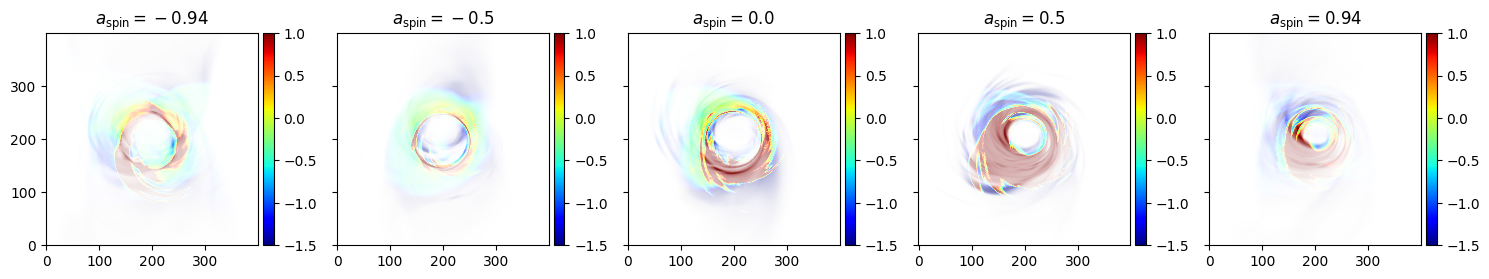

In [3]:
vizrow(pf_beta, vmax=1, vmin=-1.5, viz_type='alpha')

Rendering frequency 2281.e8
0.11075074531833581
-0.8713505838272931
-0.04040695792682564
0.5261434516428889
-0.123207166016068
Rendering frequency 2281.e8
Rendering frequency 2141.e8
3.6768692018526643
1.0067405614549396
1.9404513364588618
2.281262320756194
1.0764059768011365


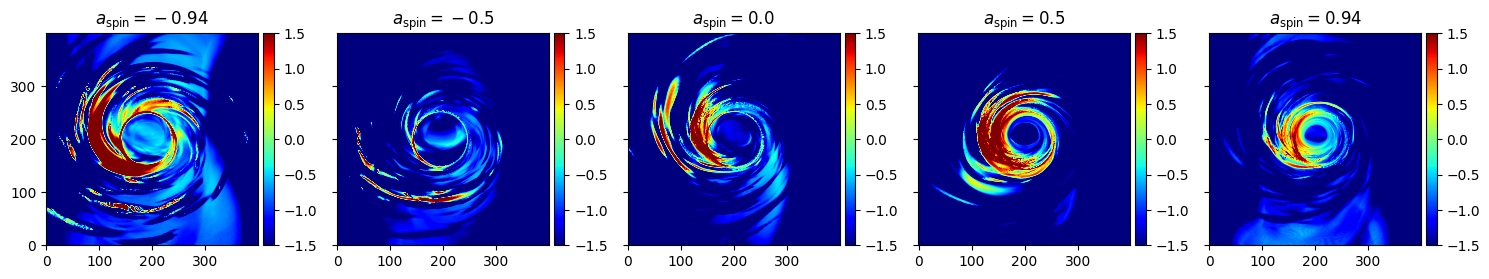

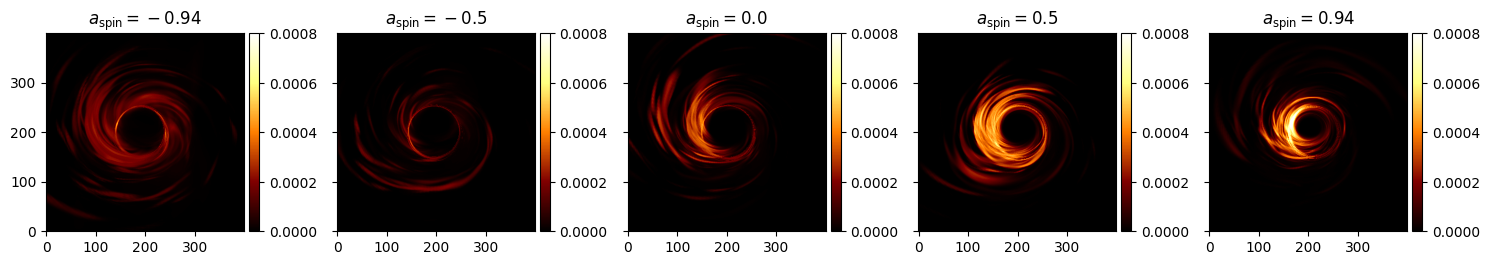

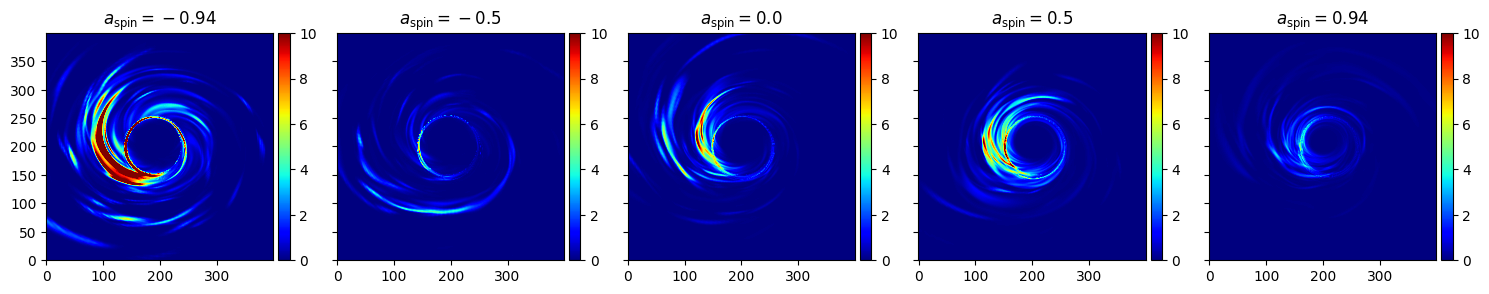

In [51]:
from common import io_ipole as io

v = freq[1]
alpha = vizrow(pf_SPO, viz_type='alpha', vmax=1.5, vmin=-1.5, v=v)
I2 = vizrow(pf_SPO, viz_type='I', vmax=0.0008, vmin=0, v=v)
tauI = vizrow(pf_SPO, viz_type='tauI',v=freq[0])

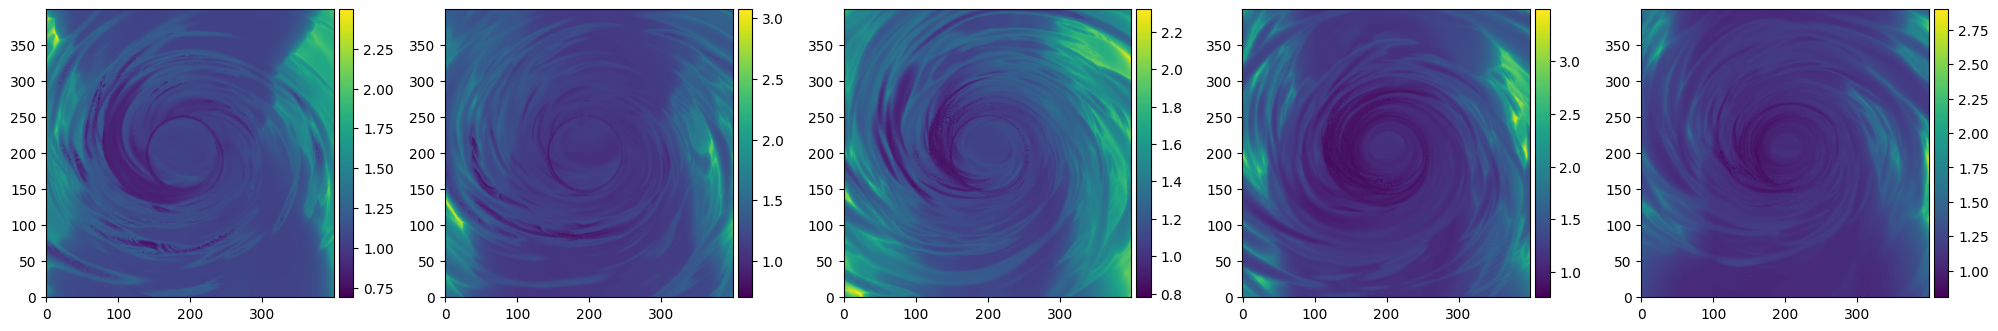

In [41]:
fig, ax = plt.subplots(1, 5, figsize=(20,20))
for i in range(5):
    tmp = I1[i]/I2[i]
    colorbar(ax[i].imshow(tmp.T,origin='lower'))
plt.tight_layout()

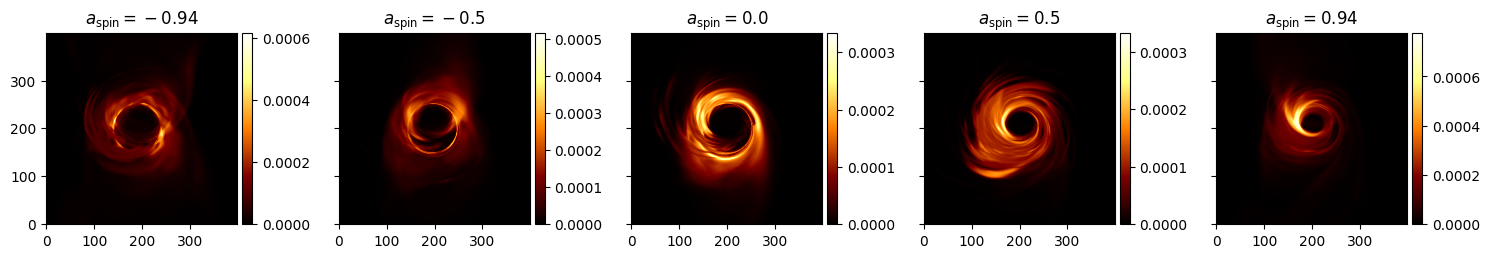

In [133]:
from common import io_ipole as io

fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for a, ax in enumerate(axes):
    sel = pf_beta(aspin=aspin[a])(freq='2141.e8')
    _, _, _, _, img = io.load_summ(sel.path.iloc[0])

    I = img.value[:,:,0]
    im = axes[a].imshow(I.T, cmap='afmhot', origin='lower')  
    colorbar(im)
    axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")
plt.tight_layout()

# Finding $\tau_v$

3.6768692018526643
1.0067405614549396
1.9404513364588618
2.281262320756194
1.0764059768011365


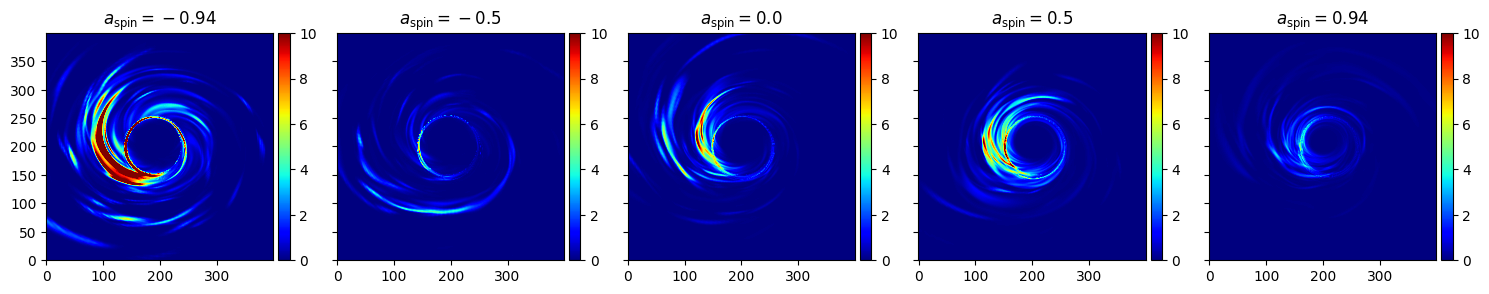

In [10]:
from common import io_ipole as io

fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for a, ax in enumerate(axes):
    sel = pf_SPO(aspin=aspin[a])(freq='2141.e8')
    _, _, _, _, img = io.load_summ(sel.path.iloc[0])

    tau = img.tauI
    I = img.value[:,:,0]
    print(np.sum(tau * I) / np.sum(I))
    im = axes[a].imshow(tau.T, cmap='jet', vmax=10, origin='lower')  
    colorbar(im)
    axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")
plt.tight_layout()

2.2727615229846916
0.6835006446655115
1.419422123029417
8.842641565662724
4.775198637364625


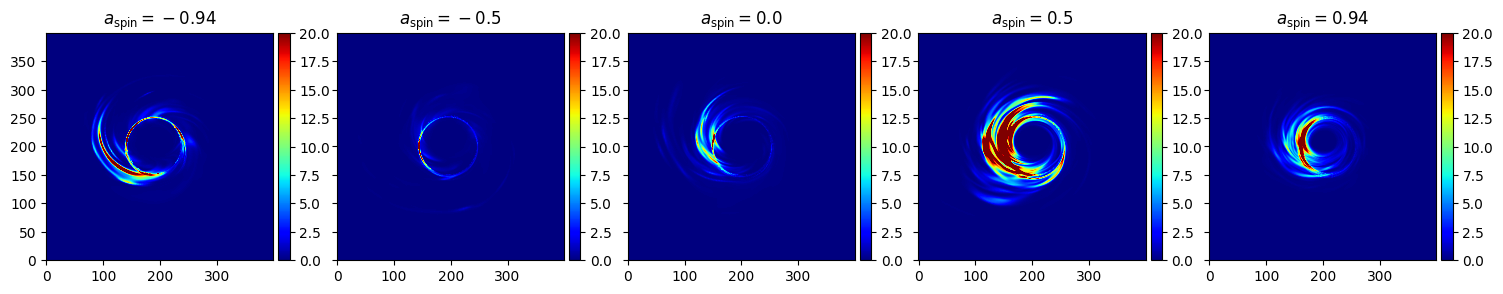

In [14]:
# Intensity-averaged optical density
from common import io_ipole as io

fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for a, ax in enumerate(axes):
    sel = pf_beta(aspin=aspin[a])(freq='2281.e8')
    _, _, _, _, img = io.load_summ(sel.path.iloc[0])

    tau = img.tauI
    I = img.value[:,:,0]
    print(np.sum(tau * I) / np.sum(I))
    im = axes[a].imshow(tau.T, cmap='jet', vmax=20, origin='lower')  
    colorbar(im)
    axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")
plt.tight_layout()